# Harris and Shi-Tomasi corners detectors implementation
Harris and Shi-Tomasi corners detectors ​implementation step by step using opencv, numpy, and matplotlib libraries.

In [1]:
## Import of numpy, matplotlib, and opencv libraries.
import numpy as np
import matplotlib.pyplot as plt
import cv2 

## Read the image "chessboard00.png" and transform it into a grayscale image
imgO = cv2.imread('chessboard00.png')           
img = cv2.cvtColor(imgO, cv2.COLOR_BGR2GRAY) 

Step 1: Compute the image intensity derivatives Ix = ∂I/∂x, Iy = ∂I/∂y in the x and y directions for each pixel.

a = [[-1]
 [ 0]
 [ 1]]
b = [[1]
 [1]
 [1]]
ab = [[-1 -1 -1]
 [ 0  0  0]
 [ 1  1  1]]
ba = [[-1  0  1]
 [-1  0  1]
 [-1  0  1]]


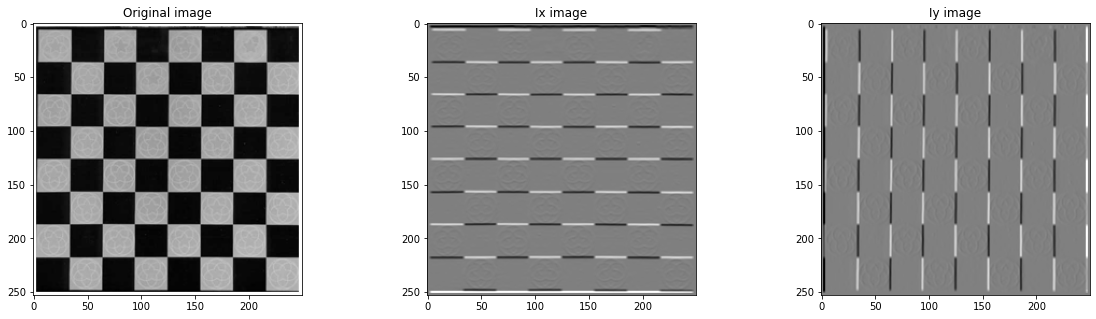

In [2]:
# Computes the kernels a(b.⊤) and b(a.⊤)
aa = np.array([[-1,0,1]])    # aa = [-1 0 1] 
a = np.transpose(aa)         # a = aa.T = [-1 0 1].⊤ 
bb = np.array([[1,1,1]])     # bb = [1 1 1] 
b = np.transpose(bb)         # b = bb.T = [1 1 1].⊤  \ with bb = (bb.T).T = b.T

ab = a*bb   # ab = a(b.⊤) = a*bb
ba = b*aa   # ba = b(a.⊤) = b*aa
print('a =', a)
print('b =', b)
print('ab =', ab)
print('ba =', ba)

# Calculation of Ix and Iy: convolution of the gray image "img" with the kernel ab => Ix, and with the kernel ba => Iy
Ix = cv2.filter2D(img, cv2.CV_32F, ab)  
Iy = cv2.filter2D(img, cv2.CV_32F, ba)  
# Remark :  "cv2.CV_32F" and not "-1"

# Image display, original image, Ix and Iy
fig, axs = plt.subplots(1,3, figsize=(20, 5))
axs[0].set_title('Original image')
axs[0].imshow(img, cmap='gray')

axs[1].set_title('Ix image')
axs[1].imshow(Ix, cmap='gray')

axs[2].set_title('Iy image')
axs[2].imshow(Iy, cmap='gray')
plt.show()

Step 2: calculation of the products Ix², Iy² and IxIy

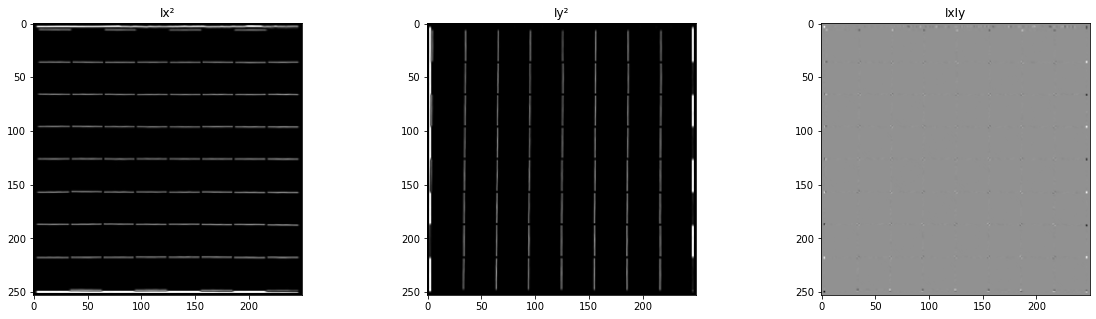

Taille de Ix² : (253, 250)
Taille de Iy² : (253, 250)
Taille de IxIy : (253, 250)


In [3]:
Ix_carre = Ix**2    
Iy_carre = Iy**2   
IxIy = Ix*Iy       

## Image display, Ix², Iy² and de IxIy 
fig, axs = plt.subplots(1,3, figsize=(20, 5))
axs[0].set_title('Ix²')
axs[0].imshow(Ix_carre, cmap='gray')

axs[1].set_title('Iy²')
axs[1].imshow(Iy_carre, cmap='gray')

axs[2].set_title('IxIy')
axs[2].imshow(IxIy, cmap='gray')
plt.show()

## Display of image sizes Ix², Iy² and IxIy
print('Taille de Ix² :', Ix_carre.shape)
print('Taille de Iy² :', Iy_carre.shape)
print('Taille de IxIy :', IxIy.shape)

Step 3: Application of the Gaussian filter (kernel 9×9, σ = 2) on the 3 images Ix², Iy² and IxIy.

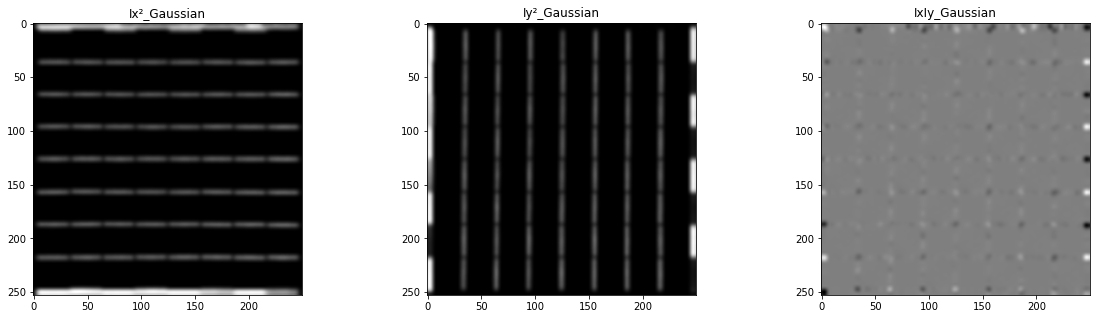

In [4]:
Ix_carre_G = cv2.GaussianBlur(Ix_carre, (9,9), 2)  
Iy_carre_G = cv2.GaussianBlur(Iy_carre, (9,9), 2)   
IxIy_G = cv2.GaussianBlur(IxIy, (9,9), 2)        

## Display of the images after the application of the Gaussian filter
fig, axs = plt.subplots(1,3, figsize=(20, 5))
axs[0].set_title('Ix²_Gaussian')
axs[0].imshow(Ix_carre_G, cmap='gray')

axs[1].set_title('Iy²_Gaussian')
axs[1].imshow(Iy_carre_G, cmap='gray')

axs[2].set_title('IxIy_Gaussian')
axs[2].imshow(IxIy_G, cmap='gray')
plt.show()

In [5]:
## Zero padding in the 3 images Ix²_Gaussian, Iy²_Gaussian and IxIy_Gaussian, to increase their sizes (e.g. pad =1), 
## and to use them in the next part of the convolution, in order to have at the end the same size of the original image.

pad = 1
## Img_pad = np.pad(Img, ((pad, pad), (pad, pad)), mode='constant', constant_values=0) ## For 2D image
Ix_carre_G_pad = np.pad(Ix_carre_G, ((pad, pad), (pad, pad)), mode='constant', constant_values=0)
Iy_carre_G_pad = np.pad(Iy_carre_G, ((pad, pad), (pad, pad)), mode='constant', constant_values=0)
IxIy_G_pad = np.pad(IxIy_G, ((pad, pad), (pad, pad)), mode='constant', constant_values=0)

## Affichage des tailles d'images Ix², Iy² et IxIy
print('Size of Ix²_Gaussian_Pad :', Ix_carre_G_pad.shape)
print('Size of Iy²_Gaussian_Pad :', Iy_carre_G_pad.shape)
print('Size of IxIy_Gaussian_Pad :', IxIy_G_pad.shape)

Size of Ix²_Gaussian_Pad : (255, 252)
Size of Iy²_Gaussian_Pad : (255, 252)
Size of IxIy_Gaussian_Pad : (255, 252)


Step 4: Search for the E matrix (Shi-Tomasi corner detector method, it contains for each point the value of the smallest eigenvalue of the auto-correlation matrix M) and the R matrix (Harris corner detector method).

In [6]:
## Remark: In this part, the code is inspired by the "Convolutional Neural Networks" course, 
#        https://www.deeplearning.ai/program/deep-learning-specialization/

# dimensions of the original grayscale image
(n_H, n_W) = img.shape

# Convolution filter W of size fxf=3x3 
W = np.array([[1,1,1], [1,1,1], [1,1,1]])
(f, f) = W.shape
 
stride = 1 # the convolution step is 1

k = 0.04   # An empirically determined constant (k ∈ [0.04,0.06]) used in the harris method
    
# Initialization of matrices with zeros
Z_Ix    = np.zeros((n_H, n_W))
Z_Iy    = np.zeros((n_H, n_W))
Z_IxIy  = np.zeros((n_H, n_W))
lambda1  = np.zeros((n_H, n_W))
lambda2  = np.zeros((n_H, n_W))
E       = np.zeros((n_H, n_W))
R       = np.zeros((n_H, n_W))

          
for h in range(n_H):           # loop on the vertical axis of the image
    # the vertical beginning and end of W
    vert_start = h*stride
    vert_end = h*stride + f
            
    for w in range(n_W):       # loop on the horizontal axis of the image
        # the horizontal beginning and end of W
        horiz_start = w*stride
        horiz_end = w*stride + f
        # the 3x3 slice in the image       
        Ix_carre_G_pad_slice = Ix_carre_G_pad[vert_start:vert_end,horiz_start:horiz_end]
        Iy_carre_G_pad_slice = Iy_carre_G_pad[vert_start:vert_end,horiz_start:horiz_end]
        IxIy_G_pad_slice     = IxIy_G_pad[vert_start:vert_end,horiz_start:horiz_end]
                         
        # Convolution of Ix, Iy and IxIy with the filter W
       
        Z_Ix[h, w]   = np.sum(Ix_carre_G_pad_slice*W)
        Z_Iy[h, w]   = np.sum(Iy_carre_G_pad_slice*W)
        Z_IxIy[h, w] = np.sum(IxIy_G_pad_slice*W)
        
        # the 2 eigenvalues of the matrix M for each pixel in the image
        lambda1[h, w]  =  np.linalg.eig(np.array([[Z_Ix[h, w]], [Z_IxIy[h, w]], [Z_IxIy[h, w]], [Z_Iy[h, w]]], float).reshape(2,2))[0][0]
        lambda2[h, w]  =  np.linalg.eig(np.array([[Z_Ix[h, w]], [Z_IxIy[h, w]], [Z_IxIy[h, w]], [Z_Iy[h, w]]], float).reshape(2,2))[0][1]

        ## Creation of the image E (shi-tomasi) and R (harris)
        # E = minimum(lambda1, lambda2) 
        E[h,w]     = np.minimum(lambda1[h, w], lambda2[h, w])
        
        # R = detM - k(traceM)², avec : detM = lambda1xlambda2 et traceM = lambda1+lambda2
        R[h, w]    = Z_Ix[h, w]*Z_Iy[h, w] - (Z_IxIy[h, w])**2 - k*((Z_Ix[h, w]+Z_Iy[h, w])**2)


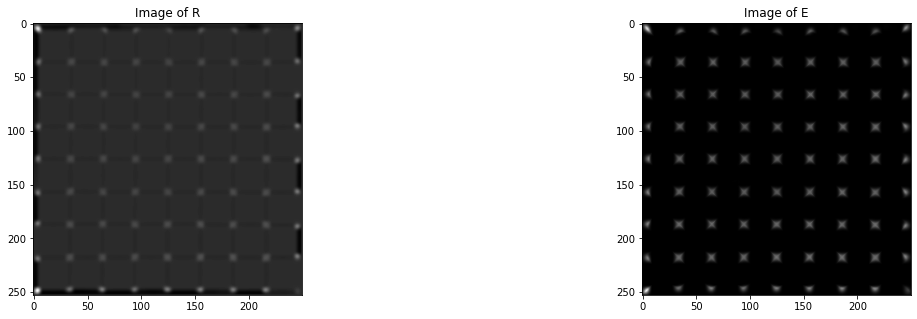

In [7]:
## Display of the image of E and R
fig, axs = plt.subplots(1,2, figsize=(20, 5))
axs[0].set_title('Image of R')
axs[0].imshow(R, cmap='gray')

axs[1].set_title('Image of E')
axs[1].imshow(E, cmap='gray')

plt.show()

Step 5: Selection of the 81 most salient points in E and R 

In [8]:
## Remark: In this part, this code is inspired by the following link: https://dsp.stackexchange.com/questions/17932/finding-local-brightness-maximas-with-opencv

def findLocalMaxima(Image):
    squareDiameterLog3 = 3 #27x27 
    pad = 5
    Image = np.pad(Image, ((pad, pad), (pad, pad)), mode='constant', constant_values=0) ## Increase the size of the image with zero-pading to detect all the maximum points in the image
    total = Image
    for axis in range(2):
        d =1
        for i in range(squareDiameterLog3):
            total = np.maximum(total, np.roll(total, d, axis))
            total = np.maximum(total, np.roll(total, -d, axis))
            d *= 3

    maxima = total == Image
    h,w = Image.shape
# Search for the coordinates of the most salient points in the image
    result = []
    for j in range(h):
        for i in range(w):
            if maxima[j][i]:
                result.append((i-pad, j-pad))
    return result

In [9]:
## The coordinates of the 81 most salient points in the R and E image
MaxR = findLocalMaxima(R)
MaxE = findLocalMaxima(E)
print('the number of most salient points in R is:', len(MaxR))
print('the number of most salient points in R is:', len(MaxE))

the number of most salient points in R is: 81
the number of most salient points in E is: 81


Step 6: display of the 81 points superimposed on the original image

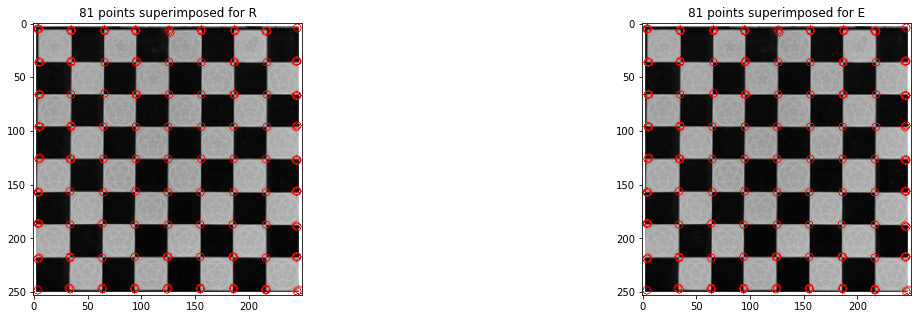

In [10]:
for i in range(len(MaxR)):
    ## MaxR = MaxE
    center_coordinatesR = MaxR[i]
    center_coordinatesE = MaxE[i]
  
    # Using cv2.circle() method
    # Draw a circle with blue line borders of thickness of 1 px
    imageR = cv2.circle(imgO, center_coordinatesR, radius=4, color= (255, 0, 0), thickness= 1)
    imageE = cv2.circle(imgO, center_coordinatesE, radius=4, color= (255, 0, 0), thickness= 1)
  
 
    ## display of the 81 points superimposed for R and E on the original image
fig, axs = plt.subplots(1,2, figsize=(20, 5))
axs[0].set_title('81 points superimposed for R')
axs[0].imshow(imageR, cmap='gray')

axs[1].set_title('81 points superimposed for E')
axs[1].imshow(imageE, cmap='gray')

plt.show()